In [32]:
import sys
from pathlib import Path
ROOT = Path().resolve().parent.parent

sys.path.append(str(ROOT))

In [33]:
from src.model.data_handler import Dataset

dataset = Dataset(csv_data=ROOT / 'data/rec_data_description.csv', IMAGE_SIZE=(64, 64), include_filter=True)

/Users/luisvalenzuela/Documents/Programs/Memoria/src/preprocess/image_quality_metrics.py:19: RuntimeWarning: invalid value encountered in divide
  data = (data - data.min()) / (data.max() - data.min()) * 255
/Users/luisvalenzuela/Documents/Programs/Memoria/venv_base/lib/python3.10/site-packages/skimage/transform/_warps.py:738: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/Users/luisvalenzuela/Documents/Programs/Memoria/venv_base/lib/python3.10/site-packages/skimage/transform/_warps.py:742: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


In [34]:
metrics = ['ssim', 'psnr', 'residual_rms']
dataset.calculate_metrics(metrics=metrics, to_filter=True)

In [35]:
object_types = ['nebula', 'galaxy']

train, val, test, scalers = dataset.get_splits(
    train_ratio=0.70, 
    val_ratio=0.15, 
    test_ratio=0.15, 
    random_state=42,
    object_types=object_types,
    normalize_metrics=True
)

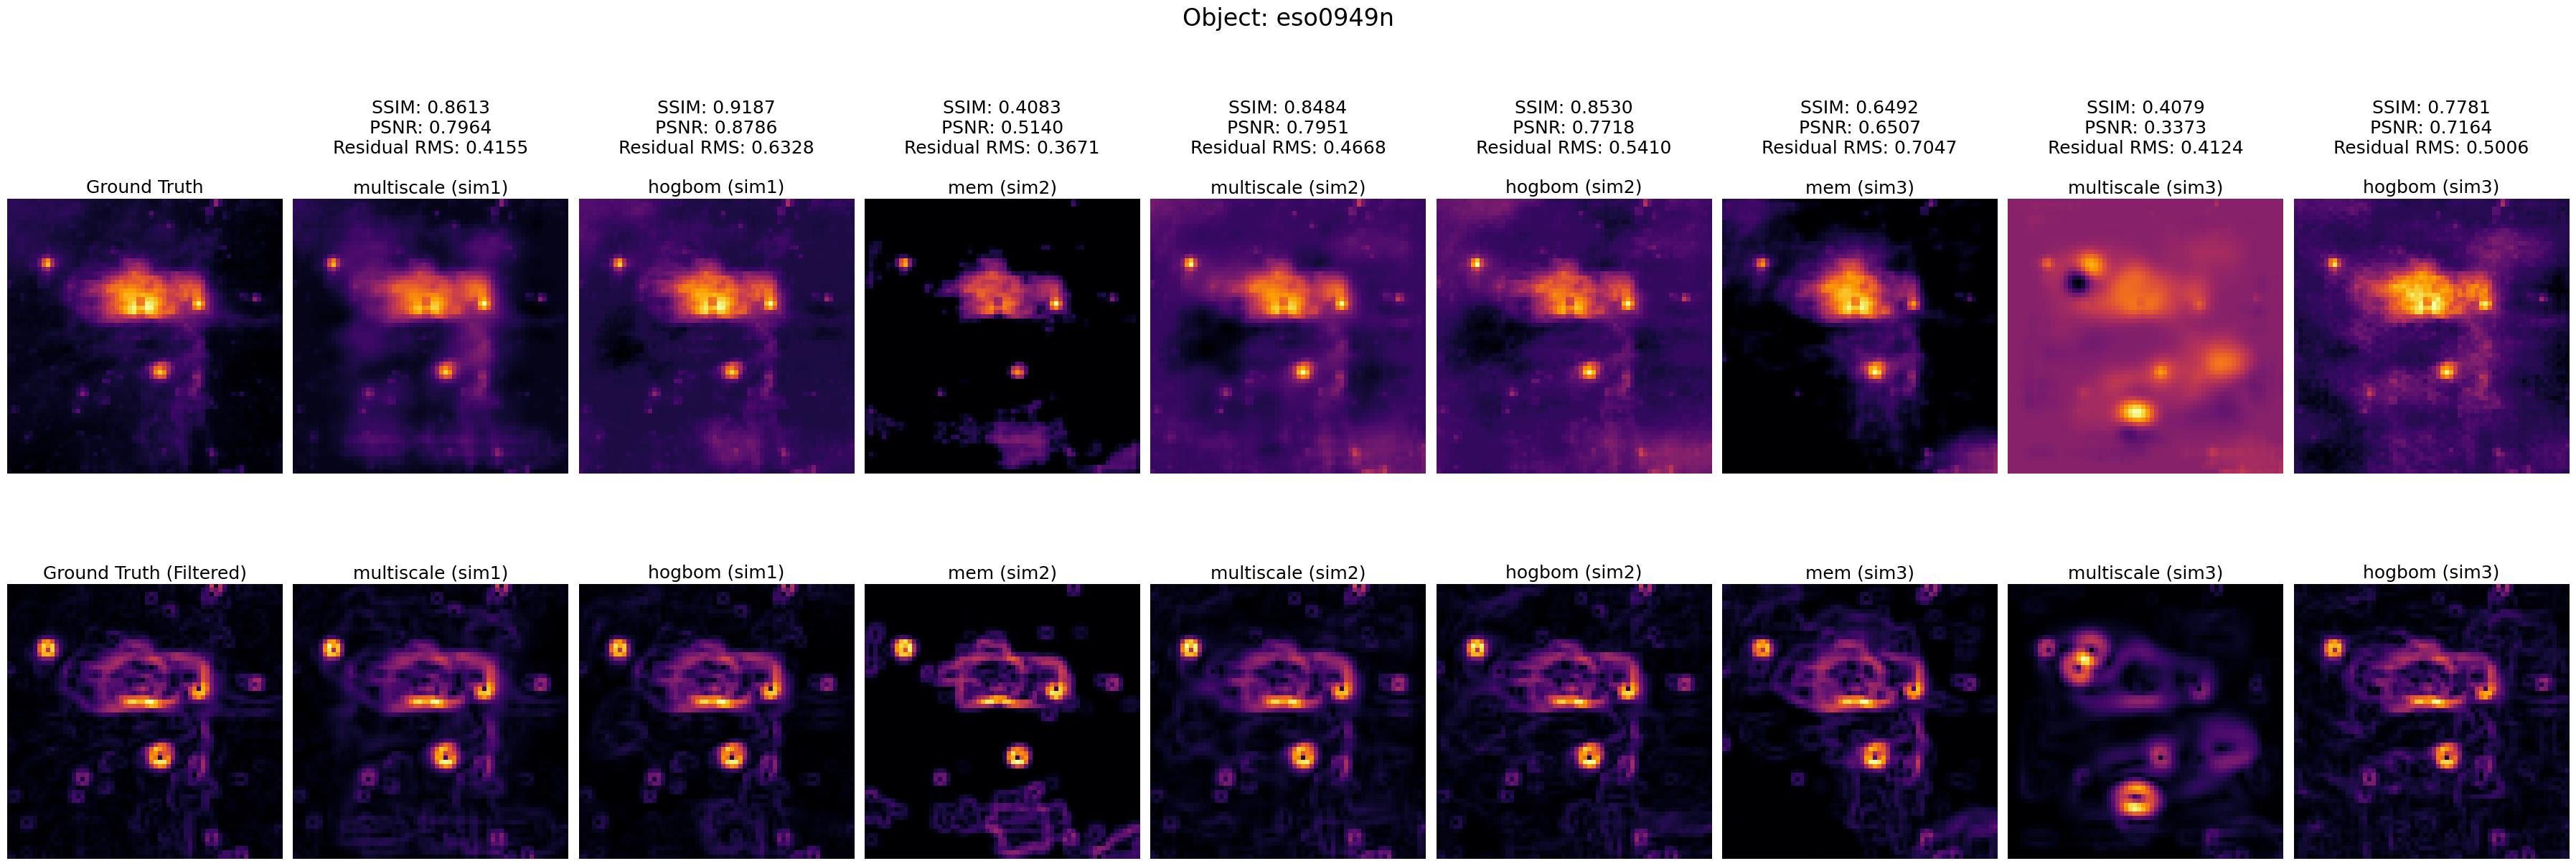

In [36]:
from src.model.utils.plot import plot_set

idx = 10
plot_set(train[idx], include_filtered=True, include_metrics=True)

In [ ]:
from src.model.utils.prepare_data import prepare_data_for_model

grouped = True
include_filtered = False
y_score = 'psnr' # Choice of 'ssim' or 'psnr'

x_train, y_train = prepare_data_for_model(train, include_filtered=include_filtered, grouped=grouped, score=y_score)
x_val, y_val = prepare_data_for_model(val, include_filtered=include_filtered, grouped=grouped, score=y_score)
x_test, y_test = prepare_data_for_model(test, include_filtered=include_filtered, grouped=grouped, score=y_score)

In [42]:
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (210, 8, 64, 64), y_train shape: (210, 8)
x_val shape: (45, 8, 64, 64), y_val shape: (45, 8)
x_test shape: (45, 8, 64, 64), y_test shape: (45, 8)


In [43]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam

class TimeReduceMean(layers.Layer):
    def call(self, z):
        return tf.reduce_mean(z, axis=1, keepdims=True)
    def compute_output_shape(self, s):
        return (s[0], 1, s[2])
    def get_config(self):
        return super().get_config()

class TimeReduceMax(layers.Layer):
    def call(self, z):
        return tf.reduce_max(z, axis=1, keepdims=True)
    def compute_output_shape(self, s):
        return (s[0], 1, s[2])
    def get_config(self):
        return super().get_config()

class TileToTime(layers.Layer):
    def call(self, inputs):
        ref, ctx = inputs
        T = tf.shape(ref)[1]
        return tf.tile(ctx, [1, T, 1])
    def compute_output_shape(self, s):
        return (s[0][0], s[0][1], s[1][2])
    def get_config(self):
        return super().get_config()

def build_encoder():
    inp = Input((64, 64, 1))
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    return Model(inp, x, name="encoder")

encoder = build_encoder()

inp_group = Input((None, 64, 64, 1), name="image_group")
encoded   = layers.TimeDistributed(encoder, name="td_encoder")(inp_group)

ctx_mean = TimeReduceMean(name="ctx_mean")(encoded)
ctx_max = TimeReduceMax(name="ctx_max")(encoded)
context = layers.Concatenate(axis=-1, name="ctx_concat")([ctx_mean, ctx_max])

ctx_tiled = TileToTime(name="ctx_tiled")([encoded, context])
x = layers.Concatenate(axis=-1, name="feat_with_ctx")([encoded, ctx_tiled])

x = layers.TimeDistributed(layers.Dense(64, activation='relu'), name="td_dense")(x)
score = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'), name="td_score")(x)

model = Model(inp_group, score, name="context_ranker")
model.compile(optimizer=Adam(1e-4), loss='mse')
model.summary()

Model: "context_ranker"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_group         │ (None, None, 64,  │          0 │ -                 │
│ (InputLayer)        │ 64, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_encoder          │ (None, None, 128) │  2,116,096 │ image_group[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctx_mean            │ (None, 1, 128)    │          0 │ td_encoder[0][0]  │
│ (TimeReduceMean)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctx_max             │ (None, 1, 128)    │          0 │ td_encoder[0][0]  │
│ (TimeReduceMax)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctx_concat          │ (None, 1, 256)    │          0 │ ctx_mean[0][0],   │
│ (Concatenate)       │                   │            │ ctx_max[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctx_tiled           │ (None, None, 256) │          0 │ td_encoder[0][0], │
│ (TileToTime)        │                   │            │ ctx_concat[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_with_ctx       │ (None, None, 384) │          0 │ td_encoder[0][0], │
│ (Concatenate)       │                   │            │ ctx_tiled[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_dense            │ (None, None, 64)  │     24,640 │ feat_with_ctx[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_score            │ (None, None, 1)   │         65 │ td_dense[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,140,801 (8.17 MB)

 Trainable params: 2,140,801 (8.17 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(x_train, y_train, epochs=500, validation_data=(x_val,y_val), callbacks=[early_stopping])

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - loss: 0.0359 - val_loss: 0.0338
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 0.0296 - val_loss: 0.0291
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.0234 - val_loss: 0.0225
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 0.0200 - val_loss: 0.0192
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.0181 - val_loss: 0.0169
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.0154 - val_loss: 0.0152
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 0.0140 - val_loss: 0.0141
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - loss: 0.0124 - val_loss: 0.0135
Epoch 10/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.0112 - val_loss: 0.0133
Epoch 11/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 0.0108 - val_loss: 0.0115
Epoch 12/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 0.0

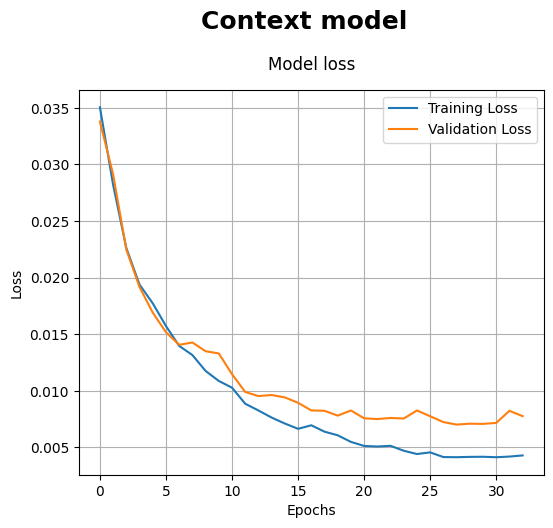

In [45]:
import matplotlib.pyplot as plt

history = model.history.history
plt.figure(figsize=(6, 5))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.suptitle(f'Context model', fontsize=18, y=1.04, fontweight='bold')
plt.title('Model loss', y=1.03)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.grid(True)
plt.legend()
plt.show()

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/stepWARNING:tensorflow:6 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x1623f0b80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
MSE: 0.011
MAE: 0.084
R2 Score: 0.654


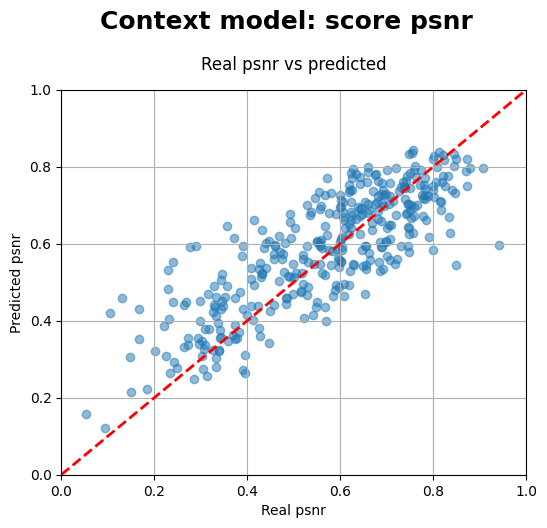

In [46]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(x_test)

y_pred_flattened = y_pred.flatten()
y_test_flattened = y_test.flatten()

print(f"MSE: {mean_squared_error(y_test_flattened, y_pred_flattened):.3f}")
print(f"MAE: {mean_absolute_error(y_test_flattened, y_pred_flattened):.3f}")
print(f"R2 Score: {r2_score(y_test_flattened, y_pred_flattened):.3f}")

test_max_ssim = max(y_test_flattened)

plt.figure(figsize=(6, 5))
plt.scatter(y_test_flattened, y_pred_flattened, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--', lw=2)
plt.xlabel(f'Real {y_score}')
plt.ylabel(f'Predicted {y_score}')
plt.suptitle(f'Context model: score {y_score}', fontsize=18, y=1.04, fontweight='bold')
plt.title(f'Real {y_score} vs predicted', y=1.03)

suma = 0.1 if test_max_ssim != 1 else 0
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
plt.show()

In [47]:
y_pred_set = model.predict(x_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [48]:
from scipy.stats import kendalltau, pearsonr, spearmanr

avg_kendalltau = 0
avg_spearmanr = 0

for y_test_i, y_pred_i in zip(y_test, y_pred_set):
    kendalltau_result, _ = kendalltau(y_test_i, y_pred_i.flatten())
    spearmanr_result, _ = spearmanr(y_test_i, y_pred_i.flatten())

    avg_kendalltau += kendalltau_result
    avg_spearmanr += spearmanr_result

avg_kendalltau /= len(y_test)
avg_spearmanr /= len(y_test)

print(f"Average Kendall's Tau: {avg_kendalltau:.3f}")
print(f"Average Spearman's rho: {avg_spearmanr:.3f}")

Average Kendall's Tau: 0.725
Average Spearman's rho: 0.835


In [49]:
idx_test = 10

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ranked_reconstructions(ground_truth, reconstructions, scores, title, n=10, cmap='inferno'):
    sorted_indices = scores.argsort()[::-1][:n]

    num_images = len(sorted_indices) + 1

    fig, axes = plt.subplots(1, num_images, figsize=(2.3 * num_images, 3))

    axes[0].imshow(ground_truth, cmap=cmap)
    axes[0].set_title("Ground truth \nimage")
    axes[0].axis('off')

    for i, ax in enumerate(axes[1:], start=0):
        idx = sorted_indices[i]
        ax.imshow(reconstructions[idx].data, cmap=cmap)
        ax.set_title(f"Score: {scores[idx]:.3f}")
        ax.axis('off')

    plt.suptitle(title, fontsize=22, y=1.03, fontweight='bold')
    plt.tight_layout()
    plt.show()

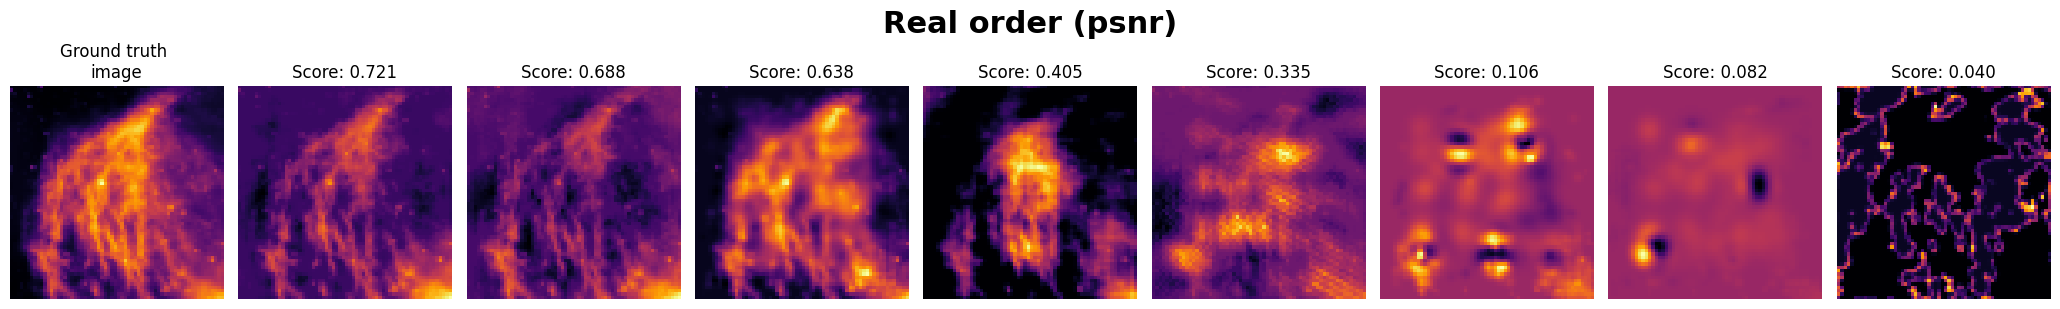

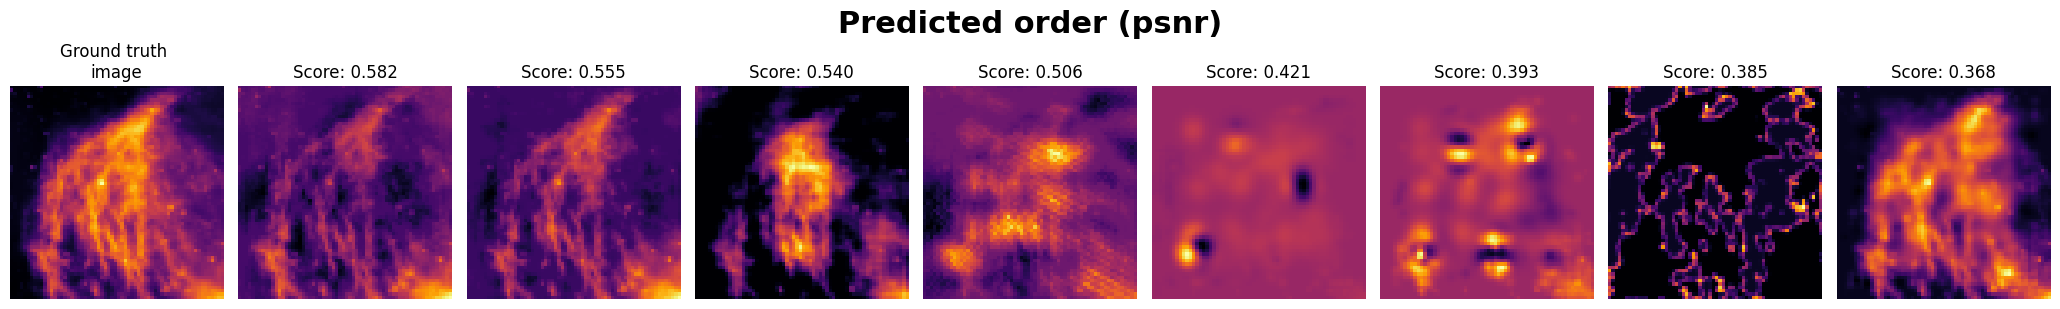

In [51]:
real_scores = np.array([
    recon.metrics.ssim.value for recon in test[idx_test].reconstructions
])

ssim_scaler = scalers['ssim']
real_scores = ssim_scaler.inverse_transform(real_scores.reshape(-1, 1)).flatten()

pred_scores = y_pred_set[idx_test, :, 0]
pred_scores = ssim_scaler.inverse_transform(pred_scores.reshape(-1, 1)).flatten()


plot_ranked_reconstructions(
    ground_truth=test[idx_test].ground_truth.data,
    reconstructions=test[idx_test].reconstructions,
    scores=real_scores,
    title=f"Real order ({y_score})",
    n=8
)

plot_ranked_reconstructions(
    ground_truth=test[idx_test].ground_truth.data,
    reconstructions=test[idx_test].reconstructions,
    scores=pred_scores,
    title=f"Predicted order ({y_score})",
    n=8
)

In [52]:
model.save(f"{y_score}_context_model.keras")